# Classification d'imageries motrices

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Dropout, Dense, Flatten
from tensorflow.keras.layers import MaxPooling1D, LSTM,  GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from scipy.fft import fft, rfftfreq
from scipy.stats.mstats import winsorize
from scipy.signal import welch
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
import seaborn as sns
import random


2025-06-14 11:56:43.058563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749902203.294342      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749902203.356174      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Initialisation du *data set*

### Chargement et formatage

In [2]:
df = pd.read_csv("/kaggle/input/eeg-motor-imagery-bciciv-2a/BCICIV_2a_all_patients.csv")
df = df.dropna()
eeg_columns = df.columns[4:]
df[eeg_columns] = df[eeg_columns].apply(pd.to_numeric, errors='coerce')
df = df.dropna()
labels = df['label'].unique()

### Présentation
All rows for same patient and same epoch represent a single signal

In [3]:
print('-' * 40)
print("📖 Structure du data set 📖")
print(f"On dispose de {len(eeg_columns)} canaux d'enregistrement {eeg_columns}")
print(f"Les 4 labels permettant de classer les données sont : {labels}")
print('-' * 40)
print(df.head(10))
print('-' * 40)

----------------------------------------
📖 Structure du data set 📖
On dispose de 22 canaux d'enregistrement Index(['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5',
       'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9',
       'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15',
       'EEG-16'],
      dtype='object')
Les 4 labels permettant de classer les données sont : ['tongue' 'foot' 'right' 'left']
----------------------------------------
   patient   time   label  epoch    EEG-Fz     EEG-0     EEG-1     EEG-2  \
0        1 -0.100  tongue      8 -1.681412  2.245496 -0.158350  1.163765   
1        1 -0.096  tongue      8  0.420417  0.587559  1.650510  0.970672   
2        1 -0.092  tongue      8  0.551365  1.499758  0.121302  2.859433   
3        1 -0.088  tongue      8  3.054916 -1.807238  1.843603  2.286812   
4        1 -0.084  tongue      8  2.506710 -2.453101  0.221178  0.127278   
5        1 -0.080  tongue      8  1.150619 -2.0

### Exploitabilité


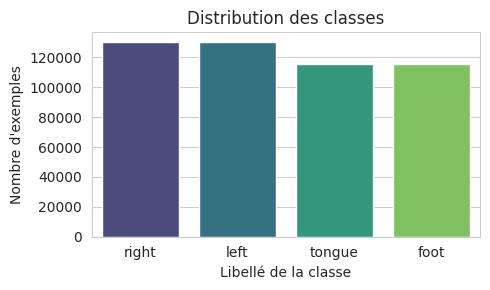

In [4]:
sns.set_style("whitegrid")
plt.figure(figsize=(5, 3))
sns.countplot(x='label', data=df, palette='viridis', order=df['label'].value_counts().index)
plt.xlabel("Libellé de la classe", fontsize=10)
plt.ylabel("Nombre d'exemples", fontsize=10)
plt.title("Distribution des classes", fontsize=12)
plt.tight_layout()
plt.show()

# Pré-traitement

## Groupement des données
Initialement, les données sont éparses ; de fait, il nous fait regrouper les amplitudes des signaux selon l'*epoch* qu'elles modélisent.

In [5]:
epochs = df.groupby('epoch')
x, y = [], []

target_length = 201

for i, epoch in epochs:
    data = epoch[eeg_columns].values.T
    if data.shape[1] > target_length:
        data = data[:, :target_length]
    elif data.shape[1] < target_length:
        pad_width = target_length - data.shape[1]
        data = np.pad(data, ((0, 0), (0, pad_width)), mode='constant')
    x.append(data)
    y.append(epoch['label'].iloc[0])
    
x = np.array(x)
y = np.array(y)
print(f"Dimension de x après regroupemment : {x.shape}")
print(f"Dimension de y après regroupemment : {y.shape}")

Dimension de x après regroupemment : (632, 22, 201)
Dimension de y après regroupemment : (632,)


--- Raw EEG Signal Visualization (Sample) ---


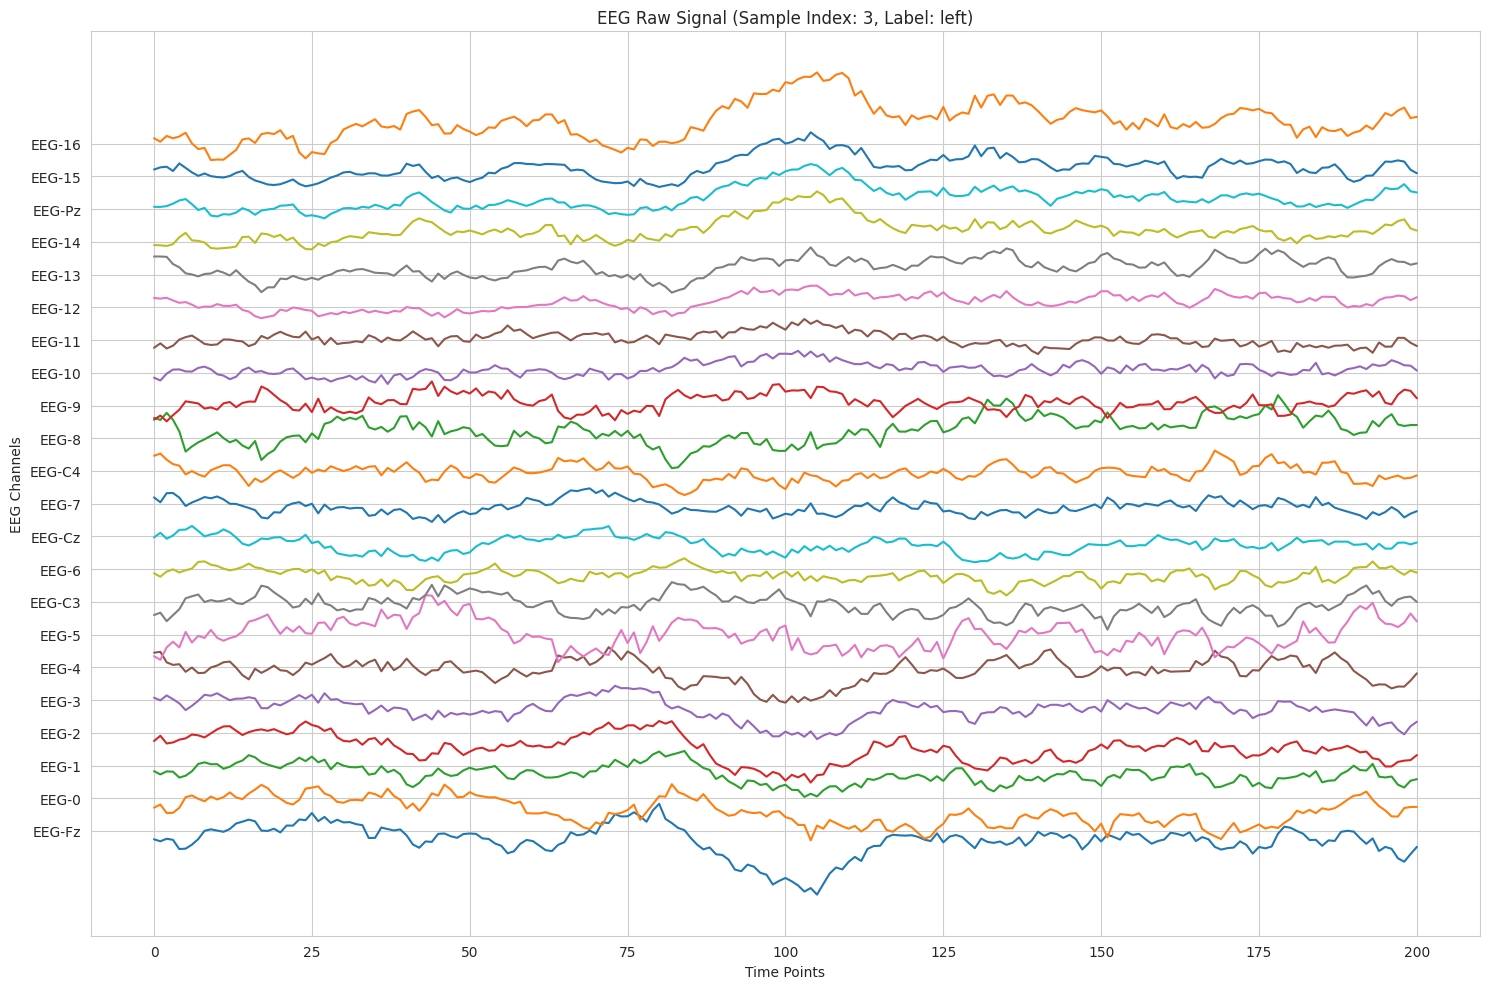

In [6]:
print("--- Raw EEG Signal Visualization (Sample) ---")
left_indices = np.where(y == 'left')[0]
sample_idx = left_indices[0]
sample_data = x[sample_idx]

plt.figure(figsize=(15, 10))
for ch in range(sample_data.shape[0]):
    plt.plot(sample_data[ch] + ch * 10, label=f'Ch {eeg_columns[ch]}')
plt.yticks([ch * 10 for ch in range(sample_data.shape[0])], eeg_columns)
plt.title(f'EEG Raw Signal (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.grid(True)
plt.tight_layout()
plt.show()

### Représentation temps/fréquence
définir le spectro


--- Spectrogram-like EEG Heatmap ---


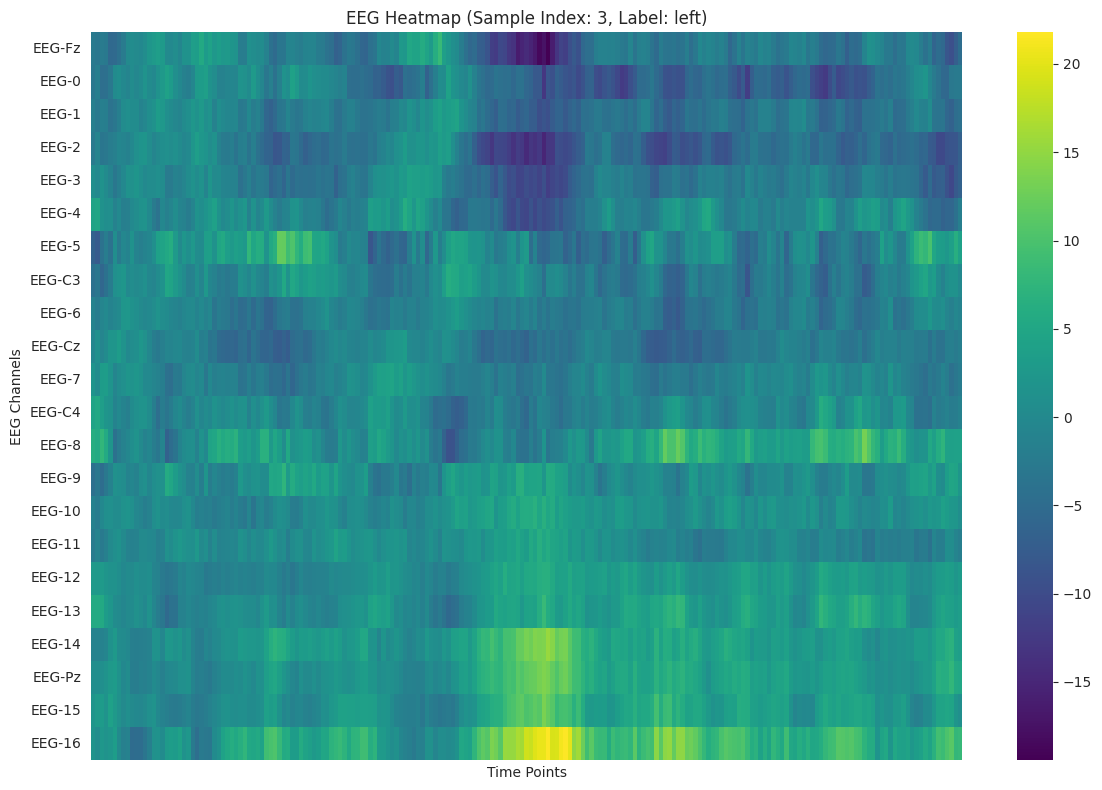

In [7]:
print("\n--- Spectrogram-like EEG Heatmap ---")
plt.figure(figsize=(12, 8))
sns.heatmap(sample_data, cmap='viridis', yticklabels=eeg_columns, xticklabels=False)
plt.title(f'EEG Heatmap (Sample Index: {sample_idx}, Label: {y[sample_idx]})')
plt.xlabel("Time Points")
plt.ylabel("EEG Channels")
plt.tight_layout()
plt.show()

## Normalisation

Pour des questions d'échelles, de stabilité, et de performance, il est nécessaire de normaliser les données. En effet :
1. L'information d'un canal à l'autre, d'une mesure à l'autre, prend place dans une plage de valeur inhérente à ceux-ci ; lesquelles pouvant notablement varier. Ici, la normalisation est vouée à prévenir toute démesure dans la place que pourrait prendre telle ou telle métrique. On s'assure de la **bonne équité de la représentation des variables ; et subséquemment, de leur influence sur le modèle**.
2. Par ailleurs, **l'apprentissage est à même de converger plus efficacement** si les données sont normalisées ; en évitant d'ailleurs les problèmes d'évanescence et d'explosion du gradient.
3. Enfin, comme toute information porte un bruit inhérent aux conditions expérimentales, ainsi qu'un variabilité naturelle ; la normalisation permet d'**éviter les problèmes de généralisations**.

Dans les expériences menées, la normalisation par z-score a démontré la plus haute précision par rapport à d'autres méthodes de normalisation telles que la normalisation logarithmique (log) et la normalisation min-max.

Avant la normalisation, les signaux de chaque électrode ont été "winsorized" pour réduire les effets des valeurs aberrantes de grande amplitude. Cela impliquait de remplacer les valeurs d'amplitude inférieures au 5ème percentile ou supérieures au 95ème percentile par ces percentiles respectifs, car la moyenne et l'écart-type sont sensibles aux valeurs aberrantes

$$S'_{ijk} = \frac{\text{winsorize}(S_{ijk}) - \mu_{ij}}{\sigma_{ij}}$$
Où :
- $S_{ijk}$ est l'amplitude brute du signal au canal ii, essai jj, temps kk
- $\text{winsorize}(S_{ijk})$ désigne le signal après winsorisation (par exemple à 5% et 95%)
- $\mu_{ij}$ est la moyenne du signal winsorisé du canal ii pour l'essai jj
- $\sigma_{ij}$ est l’écart-type correspondant

In [8]:
n_samples, n_channels, n_time_points = x.shape
x_normalized = np.zeros_like(x)

for i in range(n_samples):
    for ch in range(n_channels):
        signal = x[i, ch, :]
        signal_winsorized = winsorize(signal, limits=[0.05, 0.05])
        scaler = StandardScaler()
        x_normalized[i, ch, :] = scaler.fit_transform(signal_winsorized.reshape(-1, 1)).flatten()

Les signaux EEG sont souvent meilleurs discriminants en fréquence (ex. : tâches motrices activent certaines bandes).

Cela permet de détecter les bandes spectrales caractéristiques (delta, theta, alpha, etc.).

Ces amplitudes peuvent ensuite être utilisées comme entrées pour un modèle IA (ex. : CNN, LSTM, SVM...).

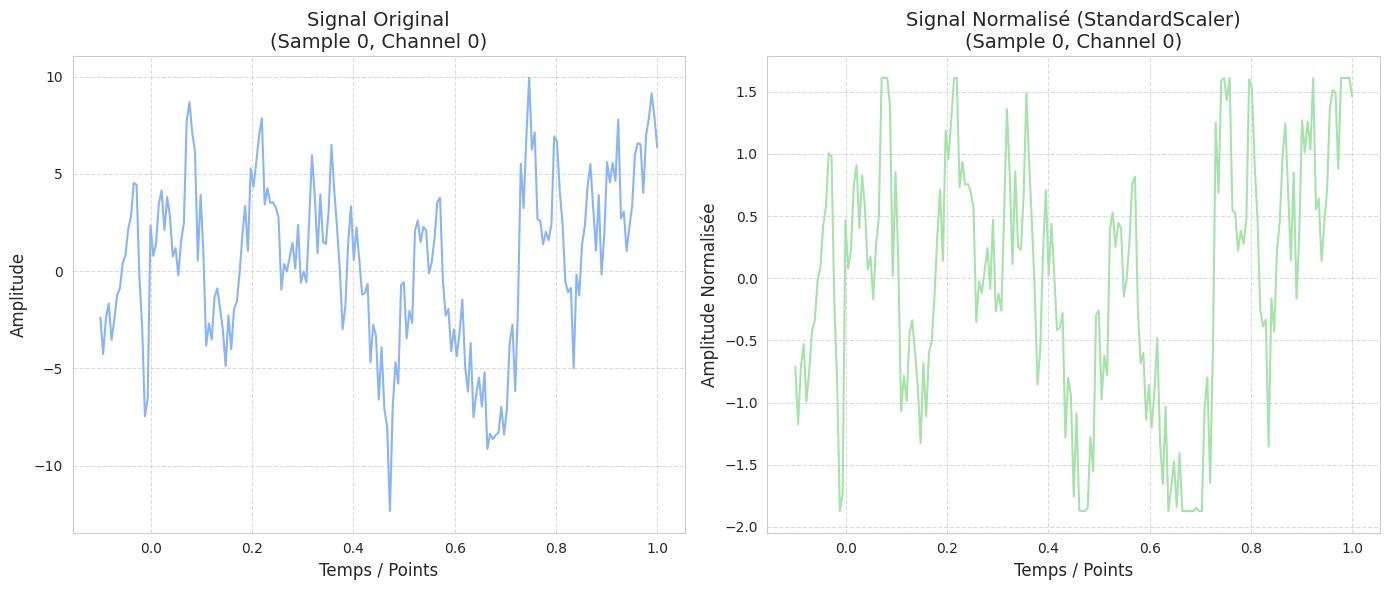

In [9]:
sample_to_plot = 0
channel_to_plot = 0
time = np.linspace(-0.1, 1, target_length)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1) 
plt.plot(time, x[sample_to_plot, channel_to_plot, :], color='#89B4FA')
plt.title(f'Signal Original\n(Sample {sample_to_plot}, Channel {channel_to_plot})', fontsize=14)
plt.xlabel('Temps / Points', fontsize=12)
plt.ylabel('Amplitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.subplot(1, 2, 2) 
plt.plot(time, x_normalized[sample_to_plot, channel_to_plot, :], color='#A6E3AA') 
plt.title(f'Signal Normalisé (StandardScaler)\n(Sample {sample_to_plot}, Channel {channel_to_plot})', fontsize=14)
plt.xlabel('Temps / Points', fontsize=12)
plt.ylabel('Amplitude Normalisée', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

***Remarque:** Effet de la winso visibles*

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5]),
 [Text(0, 0.5, 'Ch EEG-Fz'),
  Text(0, 1.5, 'Ch EEG-0'),
  Text(0, 2.5, 'Ch EEG-1'),
  Text(0, 3.5, 'Ch EEG-2'),
  Text(0, 4.5, 'Ch EEG-3'),
  Text(0, 5.5, 'Ch EEG-4'),
  Text(0, 6.5, 'Ch EEG-5'),
  Text(0, 7.5, 'Ch EEG-C3'),
  Text(0, 8.5, 'Ch EEG-6'),
  Text(0, 9.5, 'Ch EEG-Cz'),
  Text(0, 10.5, 'Ch EEG-7'),
  Text(0, 11.5, 'Ch EEG-C4'),
  Text(0, 12.5, 'Ch EEG-8'),
  Text(0, 13.5, 'Ch EEG-9'),
  Text(0, 14.5, 'Ch EEG-10'),
  Text(0, 15.5, 'Ch EEG-11'),
  Text(0, 16.5, 'Ch EEG-12'),
  Text(0, 17.5, 'Ch EEG-13'),
  Text(0, 18.5, 'Ch EEG-14'),
  Text(0, 19.5, 'Ch EEG-Pz'),
  Text(0, 20.5, 'Ch EEG-15'),
  Text(0, 21.5, 'Ch EEG-16')])

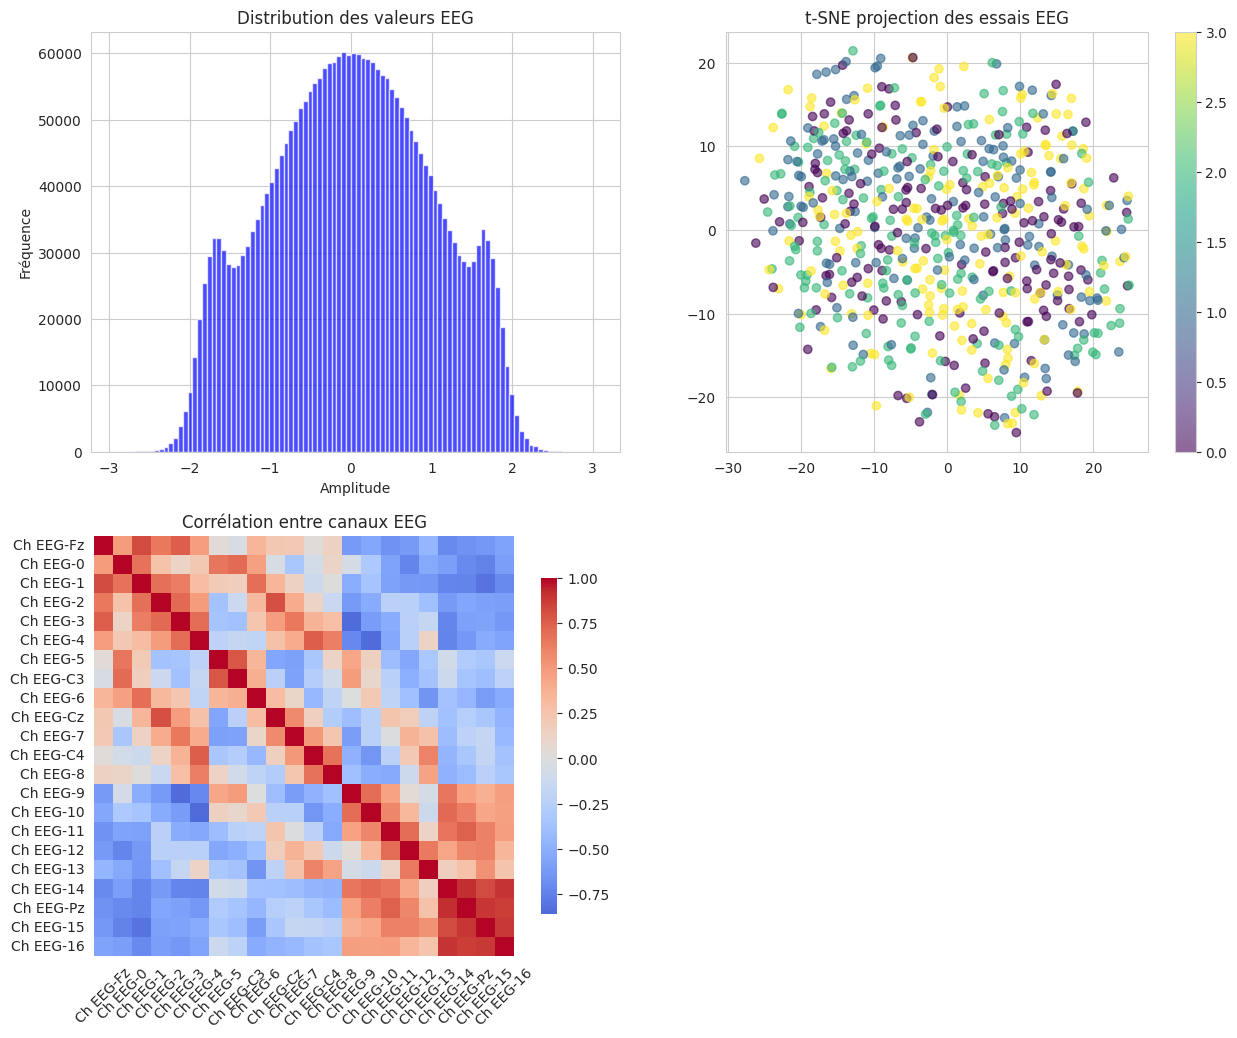

In [10]:
# 1. Distribution des valeurs EEG (inspiré de votre code)
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
plt.hist(x_normalized.flatten(), bins=100, alpha=0.7, color='blue')
plt.title("Distribution des valeurs EEG")
plt.xlabel("Amplitude")
plt.ylabel("Fréquence")

# 3. t-SNE projection (directement de votre code)
plt.subplot(2, 2, 2)
# Flatten les données pour t-SNE
X_flat = x_normalized.reshape(x_normalized.shape[0], -1)

# Sous-échantillonner si trop de données
if X_flat.shape[0] > 1000:
    idx = np.random.choice(X_flat.shape[0], 1000, replace=False)
    X_flat_sample = X_flat[idx]
    y_sample = y[idx]
else:
    X_flat_sample = X_flat
    y_sample = y

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_flat_sample)
label_encoder = LabelEncoder()
yn_encoded = label_encoder.fit_transform(y)
scatter = plt.scatter(X_embedded[:,0], X_embedded[:,1], c=yn_encoded, cmap='viridis', alpha=0.6)
plt.title("t-SNE projection des essais EEG")
plt.colorbar(scatter)

# 4. Matrice de corrélation entre canaux
plt.subplot(2, 2, 3)

sample_data = x_normalized[0]  # Premier échantillon
corr_matrix = np.corrcoef(sample_data)
ch_names = [f'Ch {eeg_columns[ch]}' for ch in range(22)]
sns.heatmap(corr_matrix, 
           xticklabels=ch_names[:len(sample_data)], 
           yticklabels=ch_names[:len(sample_data)],
           cmap='coolwarm', center=0, 
           square=True, cbar_kws={'shrink': 0.8})
plt.title("Corrélation entre canaux EEG")
plt.xticks(rotation=45)
plt.yticks(rotation=0)


| Aspect                   | Interprétation                                                                  |
| ------------------------ | ------------------------------------------------------------------------------- |
| Distribution             | Bonne normalisation (Z-score), avec quelques motifs récurrents                  |
| t-SNE                    | Les classes sont mélangées, donc difficilement séparables sans feature learning |
| Corrélation inter-canaux | Redondance présente, exploitable via réduction ou spatial filtering (CSP)       |


In [11]:
# Frequency-domain features
x_freq = np.zeros((n_samples, n_channels, n_time_points // 2 + 1))
for i in range(n_samples):
    for ch in range(n_channels):
        fft_result = fft(x_normalized[i, ch, :])
        x_freq[i, ch, :] = np.abs(fft_result[:n_time_points // 2 + 1])

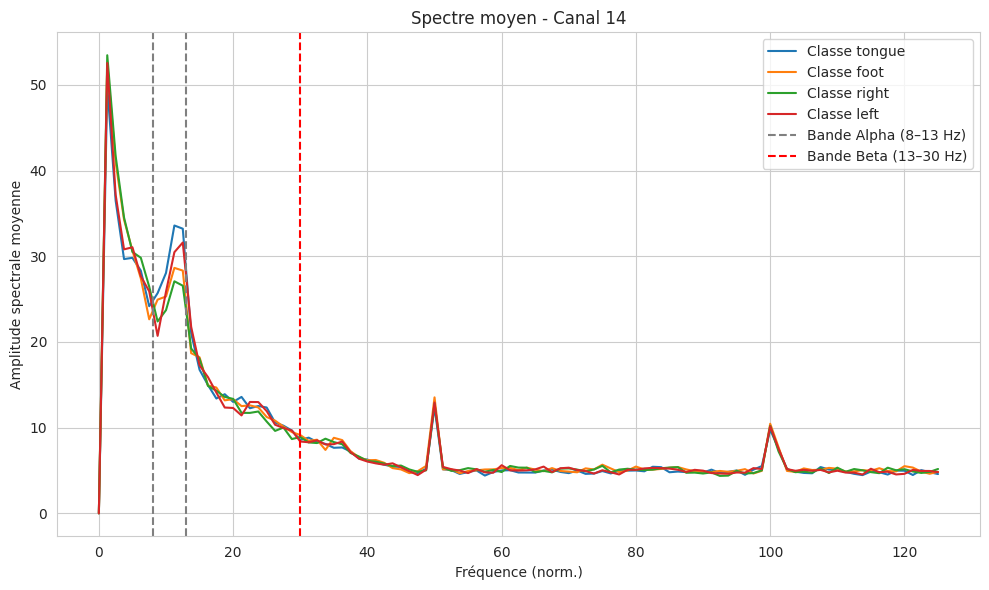

In [12]:
mean_spectra_per_class = []
for cls in labels:
    class_indices = np.where(y == cls)[0]
    class_mean_spectrum = x_freq[class_indices].mean(axis=0)  # Moyenne sur les échantillons
    mean_spectra_per_class.append(class_mean_spectrum)

channel_to_plot = 14
freqs = np.linspace(0, 250 / 2 , 101)
plt.figure(figsize=(10, 6))
for i, cls in enumerate(labels):
    plt.plot(freqs, mean_spectra_per_class[i][channel_to_plot], label=f"Classe {cls}")
plt.xlabel("Fréquence (norm.)")
plt.ylabel("Amplitude spectrale moyenne")
plt.title(f"Spectre moyen - Canal {channel_to_plot}")
plt.axvline(8, color='gray', linestyle='--', label='Bande Alpha (8–13 Hz)')
plt.axvline(13, color='gray', linestyle='--')
plt.axvline(30, color='red', linestyle='--', label='Bande Beta (13–30 Hz)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

***Remarque**: On observe un pic d'amplitude aux basses fréquences ; ce qui a de quoi dénoter de la partialité du pré-traitement, de par la persistance d'artéfacts (clignements d'yeux, etc.)*

## Augmentation des données
Afin d'assurer un apprentissage pertinent, dont le modèle résultant à la capacité de *généraliser*, il est nécessaire de disposer d'un jeu de donnée suffisammment conséquent. Subséquemment, on décide d'augmenter celui dont on dispose par la méthode du fenêtrage. En somme, on fait glisser une fenêtre de capture de dimensions données sur le signal dont on dispose afin de générer des sous-signaux en nombre.

***Remarque**: D'autres approches sont possibles ; on en donne un exemple plus loin.*

In [13]:
window_size = 50
stride = 10
x_windows, y_windows = [], []

for i in range(n_samples):
    data = x_normalized[i]
    freq_data = x_freq[i]
    num_windows = (n_time_points - window_size) // stride + 1

    for w in range(num_windows):
        start = w * stride
        end = start + window_size
        window = data[:, start:end]
        # On a réduit l'espace fréquentiel de moitié ; donc approxime linéairement la fenêtre fréquentielle
        freq_start = (start * (n_time_points // 2 + 1)) // n_time_points
        freq_end = (end * (n_time_points // 2 + 1)) // n_time_points
        freq_window = freq_data[:, freq_start:freq_end]
        # On controlle les dimensions à cause de l'approximation
        if freq_window.shape[1] < window_size:
            freq_window = np.pad(freq_window, ((0, 0), (0, window_size - freq_window.shape[1])), mode='constant')
        elif freq_window.shape[1] > window_size:
            freq_window = freq_window[:, :window_size]
        combined = np.stack([window, freq_window], axis=-1)
        x_windows.append(combined)
        y_windows.append(y[i])

x_windows = np.array(x_windows)
y_windows = np.array(y_windows)
print(f"Dimension de x_w : {x_windows.shape}")
print(f"Dimension de y_w : {y_windows.shape}")

Dimension de x_w : (10112, 22, 50, 2)
Dimension de y_w : (10112,)


In [14]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_windows)
y_categorical = tf.keras.utils.to_categorical(y_encoded)
print(f"Dimensions de y_one-hot-encoded : {y_categorical.shape}")

Dimensions de y_one-hot-encoded : (10112, 4)


Contrôle qualité

----------------------------------------
MÉTRIQUES DE QUALITÉ DES DONNÉES
Shape des données: (10112, 22, 50)
Min: -2.9189, Max: 3.0387
Moyenne: 0.0019, Std: 1.0060
Nombre de NaN: 0
Nombre d'échantillons par classe:
Ratio d'équilibrage des classes: 0.939
=> Classes bien équilibrées


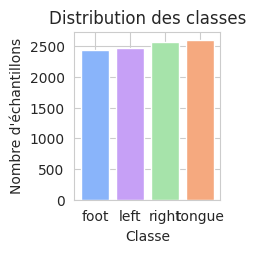

In [15]:
def plot_data_quality_metrics(X, y):
    """
    Métriques de qualité des données inspirées de vos statistiques
    """
    print('-' * 40)
    print("MÉTRIQUES DE QUALITÉ DES DONNÉES")
    print(f"Shape des données: {X.shape}")
    print(f"Min: {np.min(X):.4f}, Max: {np.max(X):.4f}")
    print(f"Moyenne: {np.mean(X):.4f}, Std: {np.std(X):.4f}")
    print(f"Nombre de NaN: {np.sum(np.isnan(X))}")
    print(f"Nombre d'échantillons par classe:")


    plt.subplot(2, 3, 5)
    unique, counts = np.unique(y, return_counts=True)
    bars = plt.bar(unique, counts, color=['#89B4FA', '#c6a0f6', '#A6E3AA', '#f5a97f'][:len(unique)])
    plt.title("Distribution des classes")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'échantillons")
    
    min_count, max_count = min(counts), max(counts)
    balance_ratio = min_count / max_count
    print(f"Ratio d'équilibrage des classes: {balance_ratio:.3f}")
    
    if balance_ratio < 0.8:
        print("=> Classes déséquilibrées détectées !")
    else:
        print("=> Classes bien équilibrées")

plot_data_quality_metrics(x_windows[:,:,:,0], y_windows)


--- EEG Band Power Calculation ---

Traitement de la classe tongue
  - 2608 fenêtres pour la classe tongue
    > fenêtre 1/2608


/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 200 is greater than input length  = 50, using nperseg = 50
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


    > fenêtre 51/2608
    > fenêtre 101/2608
    > fenêtre 151/2608
    > fenêtre 201/2608
    > fenêtre 251/2608
    > fenêtre 301/2608
    > fenêtre 351/2608
    > fenêtre 401/2608
    > fenêtre 451/2608
    > fenêtre 501/2608
    > fenêtre 551/2608
    > fenêtre 601/2608
    > fenêtre 651/2608
    > fenêtre 701/2608
    > fenêtre 751/2608
    > fenêtre 801/2608
    > fenêtre 851/2608
    > fenêtre 901/2608
    > fenêtre 951/2608
    > fenêtre 1001/2608
    > fenêtre 1051/2608
    > fenêtre 1101/2608
    > fenêtre 1151/2608
    > fenêtre 1201/2608
    > fenêtre 1251/2608
    > fenêtre 1301/2608
    > fenêtre 1351/2608
    > fenêtre 1401/2608
    > fenêtre 1451/2608
    > fenêtre 1501/2608
    > fenêtre 1551/2608
    > fenêtre 1601/2608
    > fenêtre 1651/2608
    > fenêtre 1701/2608
    > fenêtre 1751/2608
    > fenêtre 1801/2608
    > fenêtre 1851/2608
    > fenêtre 1901/2608
    > fenêtre 1951/2608
    > fenêtre 2001/2608
    > fenêtre 2051/2608
    > fenêtre 2101/2608
    > fenêtr

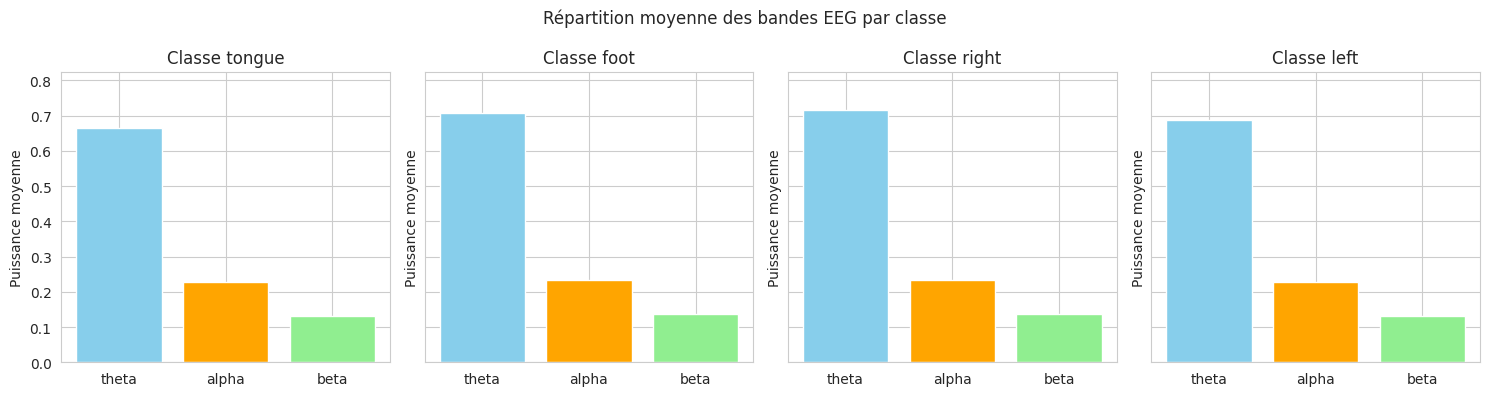

In [16]:
print("\n--- EEG Band Power Calculation ---")

def bandpower(data, sf, band, window_sec=None):
    low, high = band
    nperseg = int(window_sec * sf) if window_sec else None
    freqs, psd = welch(data, sf, nperseg=nperseg)
    idx_band = np.logical_and(freqs >= low, freqs <= high)
    return np.mean(psd[idx_band]) if np.any(idx_band) else 0.0

bands = {'theta': (4, 7), 'alpha': (8, 13), 'beta': (14, 30)}
sf = 100
mean_band_power_by_label = {}
band_power_by_label = {label: [] for label in labels}

for c in labels:
    print(f"\nTraitement de la classe {c}")
    x_c = x_windows[y_windows == c][:, :, :, 1]  # Données fréquentielles
    print(f"  - {x_c.shape[0]} fenêtres pour la classe {c}")
    for i, sample in enumerate(x_c):
        if i % 50 == 0:
            print(f"    > fenêtre {i+1}/{x_c.shape[0]}")
        band_powers = {band: [] for band in bands}
        for ch in range(n_channels):
            signal = sample[ch]
            for band, band_range in bands.items():
                bp = bandpower(signal, sf, band_range, window_sec=2)
                band_powers[band].append(bp)
        band_power_by_label[c].append(band_powers)

print("\n--- Moyennes par bande et par classe ---")
for label in labels:
    all_powers = band_power_by_label[label]
    mean_per_band = {}
    print(f"  > Classe {label}")
    for band in bands:
        band_values = [np.mean(sample[band]) for sample in all_powers]
        mean_band = np.mean(band_values)
        mean_per_band[band] = mean_band
        print(f"    - {band}: {mean_band:.4f}")
    mean_band_power_by_label[label] = mean_per_band

# Affichage
fig, axs = plt.subplots(1, len(labels), figsize=(15, 4), sharey=True)
for i, label in enumerate(labels):
    band_names = list(mean_band_power_by_label[label].keys())
    values = list(mean_band_power_by_label[label].values())
    axs[i].bar(band_names, values, color=['skyblue', 'orange', 'lightgreen'])
    axs[i].set_title(f"Classe {label}")
    axs[i].set_ylabel("Puissance moyenne")
    axs[i].set_ylim(0, max(values) * 1.2)
    axs[i].grid(True)

plt.suptitle("Répartition moyenne des bandes EEG par classe")
plt.tight_layout()
plt.show()

La bande theta domine globalement, ce qui est classique en EEG brut (surtout chez les sujets au repos ou concentrés).

La bande alpha est stable entre les classes (~0.23), typique du repos occipital mais peut apparaître selon l’état attentionnel.

La bande beta est logiquement plus faible, ce qui est attendu sans mouvement actif, mais reste légèrement plus élevée pour le pied et la main droite, ce qui pourrait suggérer une implication motrice plus marquée dans ces essais.

## Formattage pré-entraînement

In [17]:
def data_building(x, y, type = "GRU"):
    """
        Arguments :
        x (samples, time_steps, channels, features)
        y (samples, 4)
        type in {"GRU", "CNN_LSTM", "GRUR"}
        Returns :
        X_train, X_test, y_train, y_test
    """
    
    if type in ["GRU", "GRUR", "CNN_LSTM"]:
        # Reshape to : (samples, time_steps, channels * features)
        x = x.transpose(0, 2, 1, 3)
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3])
    
    return train_test_split(
        x, y, test_size=0.2, random_state=42, stratify=y
    )

X_train, X_test, y_train, y_test = data_building(x_windows,y_categorical)

# *Model Creation*

In [18]:
# Define input shape from X_train
channels = x.shape[1]
timesteps = X_train.shape[1]       # 50
features = X_train.shape[2]        # 22 * 2 = 44
num_classes = y_train.shape[1]     # 4
MODEL_TYPE = "GRU"

In [19]:
def CNN_LSTM(input_shape, num_classes, dropoutRate=0.3, l2_reg = 0.002):
    input1 = Input(shape=input_shape)

    x = Conv1D(32, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(input1)
    x = BatchNormalization()(x)
    x = Dropout(dropoutRate)(x)

    x = Conv1D(64, kernel_size=3, padding='same', activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(dropoutRate)(x)

    x = LSTM(128, return_sequences=True, dropout=dropoutRate)(x)
    x = LSTM(64, dropout=dropoutRate)(x)

    x = Dense(64, activation='elu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(dropoutRate)(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs=input1, outputs=x)

In [20]:
def GRU_Flatten_Model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    gru_out = GRU(256, return_sequences=True)(inputs)
    flatten_out = Flatten()(gru_out)
    outputs = Dense(num_classes, activation='softmax')(flatten_out)
    return Model(inputs=inputs, outputs=outputs)

In [21]:
match MODEL_TYPE:
    case "GRU":
        model = GRU_Flatten_Model(input_shape=(timesteps, features), num_classes=num_classes)
    case "GRUR":
        model = GRU_Regularized_Model(input_shape=(timesteps, features),num_classes=num_classes,dropout_rate=0.2, l2_reg=0.002)
    case "CNN_LSTM":
        model = CNN_LSTM(input_shape=(timesteps, features), num_classes=num_classes, dropoutRate=0.3, l2_reg = 0.002)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
          loss='categorical_crossentropy',
          metrics=['accuracy'])
model.summary()

2025-06-14 11:59:54.047463: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 50, 44)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50, 256)             │         231,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │          51,204 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,140 (1.08 MB)

 Trainable params: 283,140 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

# **Train Model**

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True, 
                               mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', 
                                 factor=0.5, 
                                 patience=3, 
                                 min_lr=1e-6)

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, lr_scheduler],
                    verbose=1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

Epoch 1/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.2762 - loss: 1.5833 - val_accuracy: 0.2986 - val_loss: 1.4039 - learning_rate: 5.0000e-04
Epoch 2/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.3781 - loss: 1.3245 - val_accuracy: 0.3060 - val_loss: 1.4394 - learning_rate: 5.0000e-04
Epoch 3/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.4324 - loss: 1.2424 - val_accuracy: 0.3633 - val_loss: 1.3412 - learning_rate: 5.0000e-04
Epoch 4/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.5155 - loss: 1.1337 - val_accuracy: 0.3470 - val_loss: 1.3922 - learning_rate: 5.0000e-04
Epoch 5/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 75ms/step - accuracy: 0.5463 - loss: 1.0404 - val_accuracy: 0.4167 - val_loss: 1.2948 - learning_rate: 5.0000e-04
Epoch 6/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.6758 - loss: 0.8404 - val_accuracy: 0.4671 - val_loss: 1.2438 - learning_rate: 5.0000e-04
Epoch 7/100
253/253 ━━━━━━━━━━━━━━━━━━━━ 19s 7

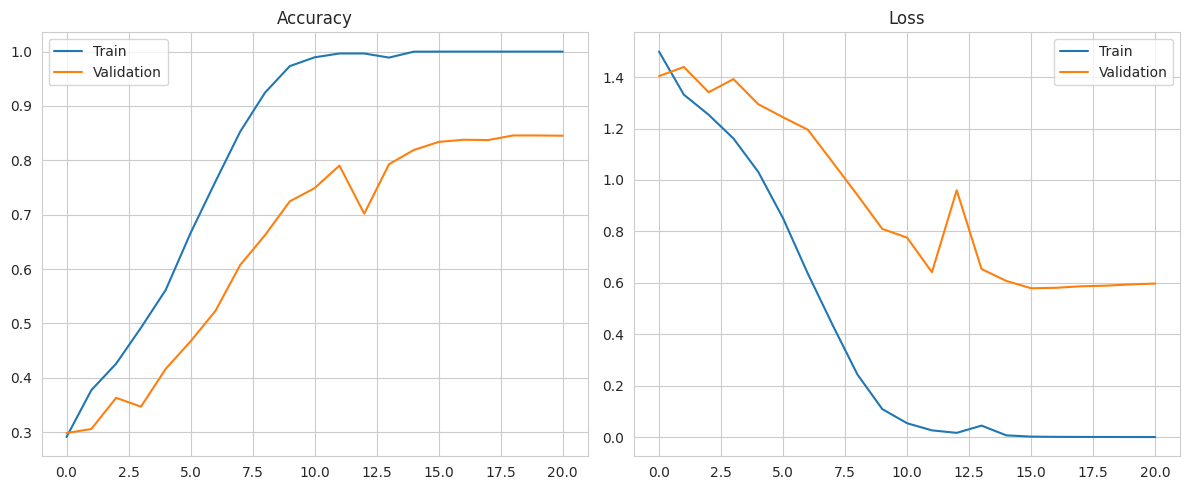

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_plot.png")
plt.show()

64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


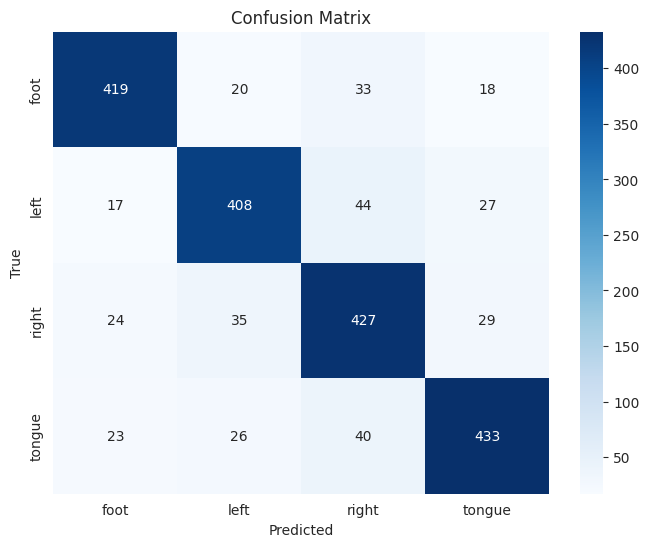

Classification Report:
              precision    recall  f1-score   support

        foot       0.87      0.86      0.86       490
        left       0.83      0.82      0.83       496
       right       0.78      0.83      0.81       515
      tongue       0.85      0.83      0.84       522

    accuracy                           0.83      2023
   macro avg       0.84      0.83      0.83      2023
weighted avg       0.83      0.83      0.83      2023



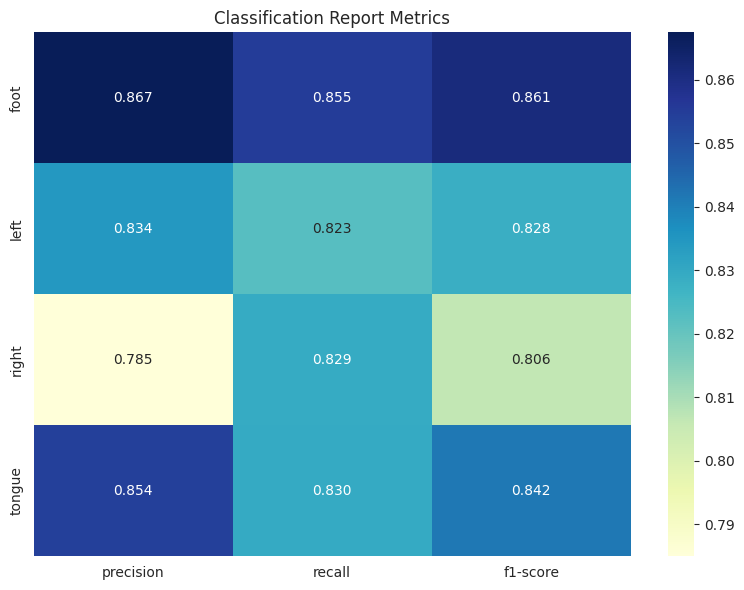

In [24]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


report = classification_report(y_true, y_pred, target_names=labels,output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-3, :-1].astype(float), 
            annot=True, cmap='YlGnBu', fmt='.3f')
plt.title('Classification Report Metrics')
plt.tight_layout()
plt.savefig('classification_report_heatmap.png', dpi=300)

# Approfondissement